In [1]:
# ------------------------------------------------------
# Retirement Calculator
# Author: John Kasson
# ------------------------------------------------------

import Simulation as sim

In [2]:
# -------------------------------------------------------
# User/Market Information - Update before running
# -------------------------------------------------------

# Number of Simulations
number_of_simulations = 1000

# Income and Starting Balance
pre_tax_annual_income = 125000
annual_raise_percentage = 0.04

# Roth 401k
starting_balance_roth = 10000
percentage_roth_contribution = 0.06
roth_growth_rate = 0.03
employer_match_bracket = [0.01, 0.06]
employer_match_rate = [1, 0.5, 0]

# Brokerage
starting_balance_brokerage = 0
percentage_brokerage_contribution = 0.20
brokerage_growth_rate = 0.02
weighted_average_expense_ratio = 0.003

# Anticipated Expenses
anticipated_expenses = [ # [Age, expense]
                        [26, 20000],  # New Car
                        [32, 50000],  # House downpayment
                        [40, 20000],  # Child 1 brokerage account
                        [42, 20000]   # Child 2 brokerage account
                       ]

# Market Information
market_growth_rate = 0.08
market_growth_uncertainty = 0.01
market_cycle_time = 8   # Time in years
market_cycle_uncertainty = 0.5
market_volatility = 0.40
market_volatility_uncertainty = 0.10
market_fluctuation_strength = 0.15

# Age and Marital Status
current_age = 23
retirement_age = 50
marriage_status = True

# Federal Tax Rates
federal_tax_bracket = [11925, 48475, 103350, 197300, 250525, 626350]
federal_tax_rate = [0.10, 0.12, 0.22, 0.24, 0.32, 0.35, 0.37]

# Capital Gains Tax Rates
capital_gains_bracket_single = [48350, 533400]
capital_gains_bracket_married = [96700, 600050]
capital_gains_rate = [0.10, 0.15, 0.20]

In [3]:
# -------------------------------------------------------
# Create and Run Simulations - Continue to next cell
# -------------------------------------------------------

# Create simulations
simulation_array = [None] * number_of_simulations
for i in range(number_of_simulations):

    # Input information to genreate simulations
    income = sim.Income(pre_tax_annual_income, annual_raise_percentage, federal_tax_bracket.copy(), federal_tax_rate.copy())
    savings = sim.Savings(sim.Roth401K(starting_balance_roth, percentage_roth_contribution, roth_growth_rate, employer_match_bracket.copy(), employer_match_rate.copy()),
                          sim.Brokerage(starting_balance_brokerage, percentage_brokerage_contribution, brokerage_growth_rate, weighted_average_expense_ratio, capital_gains_bracket_single.copy(), capital_gains_bracket_married.copy(), capital_gains_rate.copy()))
    personal = sim.Personal(current_age, retirement_age, marriage_status, anticipated_expenses)
    market = sim.Market(market_growth_rate, market_growth_uncertainty, market_cycle_time, market_cycle_uncertainty, market_volatility, market_volatility_uncertainty, market_fluctuation_strength)
    simulation_array[i] = sim.Simulation(income, savings, personal, market)
    
# Run simulations
for simulation in simulation_array:
    simulation.run()

In [4]:
# -------------------------------------------------------
# View statistics for simulations by quartile
# -------------------------------------------------------

# Sort simulations by net worth at the time of retirement
simulations_sorted = sorted(simulation_array, key=lambda x:x.get_retirement_savings())

# Print retirement savings for median, lower quartile, and upper quartile
print("Median retirement savings across " + str(number_of_simulations) + " simulations:")
print("Lower quartile:  \033[1m" + str(round(simulations_sorted[int((number_of_simulations - 1) * 0.25)].get_retirement_savings(), 2)) + "\033[0m")
print("Middle quartile: \033[1m" + str(round(simulations_sorted[int((number_of_simulations - 1) * 0.50)].get_retirement_savings(), 2)) + "\033[0m")
print("Upper quartile:  \033[1m" + str(round(simulations_sorted[int((number_of_simulations - 1) * 0.75)].get_retirement_savings(), 2)) + "\033[0m")
print("")
print("Median monthly withdrawal after taxes at age " + str(retirement_age) + " using a modification of the 4% rule:")
print("Lower quartile:  \033[1m" + str(round(simulations_sorted[int((number_of_simulations - 1) * 0.25)].get_withdrawal_safe_current(), 2)) + "\033[0m")
print("Middle quartile: \033[1m" + str(round(simulations_sorted[int((number_of_simulations - 1) * 0.50)].get_withdrawal_safe_current(), 2)) + "\033[0m")
print("Upper quartile:  \033[1m" + str(round(simulations_sorted[int((number_of_simulations - 1) * 0.75)].get_withdrawal_safe_current(), 2)) + "\033[0m")
print("")
print("Median monthly withdrawal after taxes at age 60 using the 4% rule:")
print("Lower quartile:  \033[1m" + str(round(simulations_sorted[int((number_of_simulations - 1) * 0.25)].get_withdrawal_safe_over_60(), 2)) + "\033[0m")
print("Middle quartile: \033[1m" + str(round(simulations_sorted[int((number_of_simulations - 1) * 0.50)].get_withdrawal_safe_over_60(), 2)) + "\033[0m")
print("Upper quartile:  \033[1m" + str(round(simulations_sorted[int((number_of_simulations - 1) * 0.75)].get_withdrawal_safe_over_60(), 2)) + "\033[0m")

Median retirement savings across 1000 simulations:
Lower quartile:  3957258
Middle quartile: 4561680
Upper quartile:  5233410

Median monthly withdrawal after taxes at age 50 using a modification of the 4% rule:
Lower quartile:  4438.85
Middle quartile: 5113.57
Upper quartile:  5896.58

Median monthly withdrawal after taxes at age 60 using the 4% rule:
Lower quartile:  5710.49
Middle quartile: 6583.42
Upper quartile:  7546.19


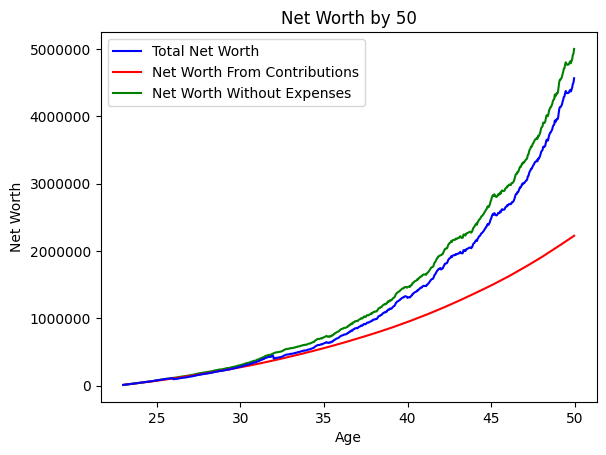

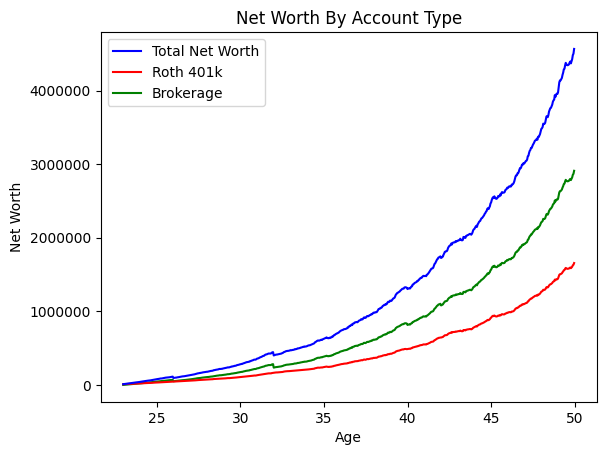

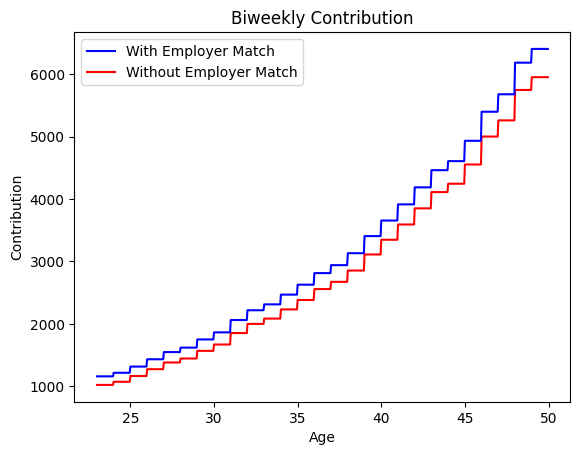

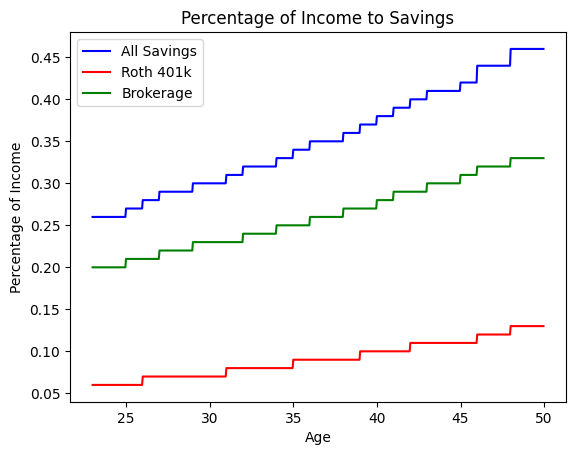

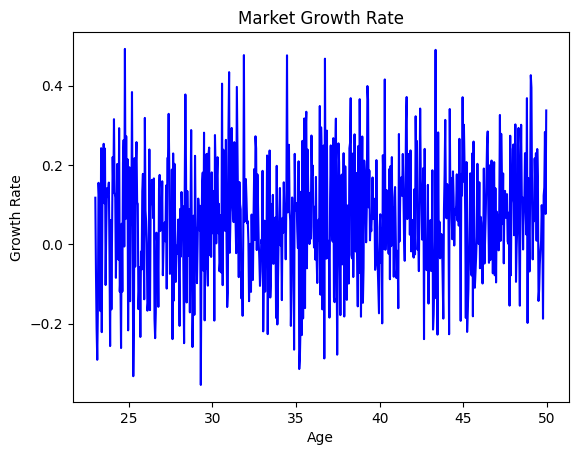

In [5]:
# -------------------------------------------------------------------------------------------
# View in-depth analysis on individual simulations
#
# To view a different simulations, input the simulation number below and re-run this cell.
# Simulations are sorted by net worth at the time of retirement
# -------------------------------------------------------------------------------------------

# View the in-depth analysis of any simulation
simulations_sorted[int(0.50 * number_of_simulations)].output()